# AI-Enabled Anomaly Detection for Enhancing Meteorological Mast Sensor Data Quality

**EEE 511 - AI Applications Midterm Project**

This notebook implements an LSTM Autoencoder for anomaly detection in Meteorological Mast sensor data and compares its performance with traditional rule-based quality control methods.

## Project Overview
- **Objective**: Develop an AI-based approach for Meteorological Mast sensor data quality assurance
- **Primary Method**: LSTM Autoencoder for temporal anomaly detection
- **Baseline**: Traditional rule-based quality control system
- **Dataset**: Multivariate wind sensor time-series data

## 1. Import Libraries and Load Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Libraries imported successfully!")

TensorFlow version: 2.20.0
Libraries imported successfully!


In [ ]:
data_path = r"c:\Users\latik\Downloads\Wind_SampleData.csv"

try:
    df = pd.read_csv(data_path)
    print("Data loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    print("\nColumn names:")
    print(df.columns.tolist())
except FileNotFoundError:
    print(f"File not found at {data_path}")
    print("Creating sample data for demonstration...")
    
    dates = pd.date_range('2018-12-01', periods=8760, freq='10min')
    np.random.seed(42)
    
    df = pd.DataFrame({
        'Datetime': dates,
        'WS100N': np.random.normal(8, 2, len(dates)) + 2*np.sin(np.arange(len(dates))*2*np.pi/144),
        'WS100S': np.random.normal(8.1, 2.1, len(dates)) + 2*np.sin(np.arange(len(dates))*2*np.pi/144),
        'WS80': np.random.normal(6, 1.5, len(dates)),
        'WS50': np.random.normal(5, 1.2, len(dates)),
        'WS20': np.random.normal(3, 1, len(dates)),
        'WP': np.random.normal(1012, 5, len(dates)),
        'WD98': np.random.uniform(0, 360, len(dates)),
        'WD78': np.random.uniform(0, 360, len(dates)),
        'WD48': np.random.uniform(0, 360, len(dates)),
        'TEMP': np.random.normal(20, 5, len(dates)),
        'HUM': np.random.normal(50, 15, len(dates))
    })
    
    anomaly_indices = np.random.choice(len(df), size=int(0.05*len(df)), replace=False)
    df.loc[anomaly_indices, 'WS100N'] = np.random.uniform(25, 35, len(anomaly_indices))
    
    print(f"Sample dataset created with shape: {df.shape}")

print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nBasic statistics:")
print(df.describe())

Data loaded successfully!
Dataset shape: (52560, 12)

Column names:
['Datetime', 'WS100N', 'WS100S', 'WS80', 'WS50', 'WS20', 'WP', 'WD98', 'WD78', 'WD48', 'TEMP', 'HUM']

First few rows:
              Datetime  WS100N  WS100S   WS80   WS50   WS20      WP  WD98  \
0  2018/12/01 00:00:00  10.654  10.809  5.182  7.096  4.852  1012.2  52.0   
1  2018/12/01 00:10:00  10.531  10.688  5.334  7.415  4.953  1012.1  53.4   
2  2018/12/01 00:20:00   9.976  10.110  5.319  7.398  4.796  1012.2  53.4   
3  2018/12/01 00:30:00   9.617   9.735  5.319  7.430  4.749  1012.1  52.0   
4  2018/12/01 00:40:00   9.001   9.112  5.363  7.344  4.833  1012.0  53.4   

   WD78  WD48  TEMP   HUM  
0  45.0  29.5  22.5  46.5  
1  47.8  32.3  22.2  47.5  
2  46.4  29.5  22.1  48.3  
3  46.4  30.9  22.2  48.5  
4  47.8  32.3  22.2  49.0  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    ----

Missing values per column:
WS100N       59
WS100S    23164
WS80       7473
WS50         59
WS20       3213
WP           59
WD98       6441
WD78       6441
WD48       6441
TEMP       6446
HUM        6441
dtype: int64
Missing values filled.


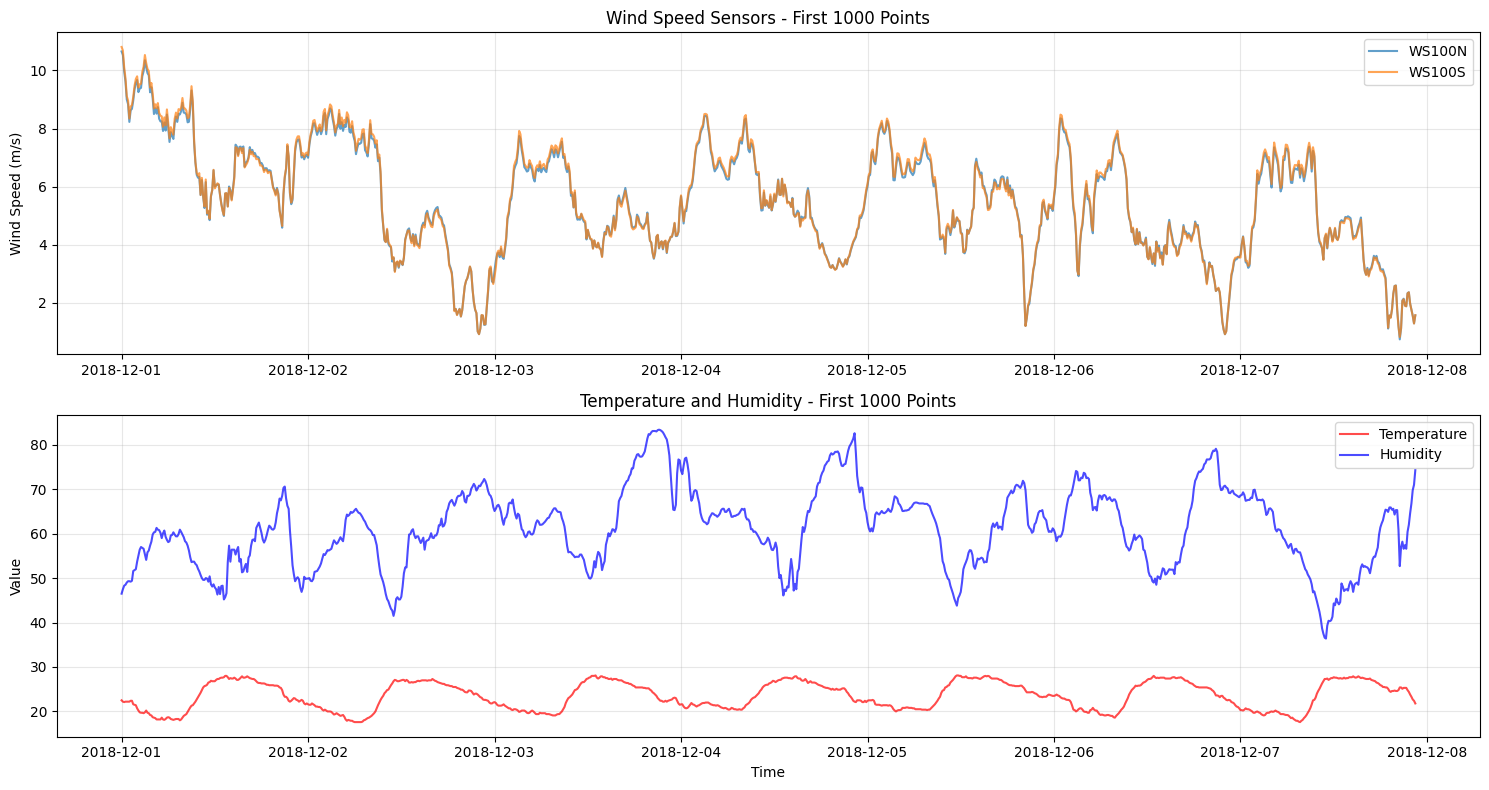

Data preprocessing completed. Final shape: (52560, 11)


In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

print(f"Missing values per column:")
print(df.isnull().sum())

if df.isnull().sum().sum() > 0:
    df = df.fillna(method='ffill').fillna(method='bfill')
    print("Missing values filled.")

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(df.index[:1000], df['WS100N'][:1000], label='WS100N', alpha=0.7)
plt.plot(df.index[:1000], df['WS100S'][:1000], label='WS100S', alpha=0.7)
plt.title('Wind Speed Sensors - First 1000 Points')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(df.index[:1000], df['TEMP'][:1000], label='Temperature', color='red', alpha=0.7)
plt.plot(df.index[:1000], df['HUM'][:1000], label='Humidity', color='blue', alpha=0.7)
plt.title('Temperature and Humidity - First 1000 Points')
plt.ylabel('Value')
plt.xlabel('Time')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Data preprocessing completed. Final shape: {df.shape}")

## 2. Traditional Rule-Based Quality Control Implementation

Based on the NIWE internship report, we implement the traditional QC system with three main components:
- **Physical Range Tests**: Check if sensor values are within physically reasonable bounds
- **Gradient Tests**: Detect rapid changes that may indicate sensor malfunctions
- **Relational Consistency Tests**: Check relationships between related sensors

In [ ]:
def apply_traditional_qc(df):
    df_qc = df.copy()
    
    df_qc['Flag'] = 0
    df_qc['GFlag'] = 0
    df_qc['Rflag'] = 0
    
    print("Applying Physical Range Tests...")
    
    ws_columns = ['WS100N', 'WS100S', 'WS80', 'WS50', 'WS20']
    for col in ws_columns:
        if col in df_qc.columns:
            df_qc.loc[(df_qc[col] < 0) | (df_qc[col] > 40), 'Flag'] = 1
    
    if 'TEMP' in df_qc.columns:
        df_qc.loc[(df_qc['TEMP'] < -50) | (df_qc['TEMP'] > 60), 'Flag'] = 1
    
    if 'HUM' in df_qc.columns:
        df_qc.loc[(df_qc['HUM'] < 0) | (df_qc['HUM'] > 100), 'Flag'] = 1
    
    if 'WP' in df_qc.columns:
        df_qc.loc[(df_qc['WP'] < 900) | (df_qc['WP'] > 1100), 'Flag'] = 1
    
    wd_columns = ['WD98', 'WD78', 'WD48']
    for col in wd_columns:
        if col in df_qc.columns:
            df_qc.loc[(df_qc[col] < 0) | (df_qc[col] > 360), 'Flag'] = 1
    
    print(f"Physical range test flags: {df_qc['Flag'].sum()} points flagged")
    
    print("Applying Gradient Tests...")
    
    for col in ws_columns:
        if col in df_qc.columns:
            df_qc[f'{col}_diff'] = df_qc[col].diff().abs()
            df_qc.loc[df_qc[f'{col}_diff'] > 10, 'GFlag'] = 1
    
    if 'TEMP' in df_qc.columns:
        df_qc['TEMP_diff'] = df_qc['TEMP'].diff().abs()
        df_qc.loc[df_qc['TEMP_diff'] > 15, 'GFlag'] = 1
    
    print(f"Gradient test flags: {df_qc['GFlag'].sum()} points flagged")
    
    print("Applying Relational Consistency Tests...")
    
    if all(col in df_qc.columns for col in ['WS100N', 'WS50']):
        df_qc.loc[df_qc['WS50'] > (df_qc['WS100N'] + 5), 'Rflag'] = 1
    
    if all(col in df_qc.columns for col in ['WD98', 'WD78']):
        wd_diff = np.abs(df_qc['WD98'] - df_qc['WD78'])
        wd_diff = np.minimum(wd_diff, 360 - wd_diff)
        df_qc.loc[wd_diff > 90, 'Rflag'] = 1
    
    print(f"Relational consistency test flags: {df_qc['Rflag'].sum()} points flagged")
    
    df_qc['Any_Flag'] = (df_qc['Flag'] > 0) | (df_qc['GFlag'] > 0) | (df_qc['Rflag'] > 0)
    
    temp_cols = [col for col in df_qc.columns if col.endswith('_diff')]
    df_qc = df_qc.drop(columns=temp_cols)
    
    total_flagged = df_qc['Any_Flag'].sum()
    total_points = len(df_qc)
    print(f"\nTraditional QC Results:")
    print(f"Total points flagged: {total_flagged} out of {total_points} ({100*total_flagged/total_points:.2f}%)")
    print(f"Clean data points: {total_points - total_flagged} ({100*(total_points-total_flagged)/total_points:.2f}%)")
    
    return df_qc

df_with_qc = apply_traditional_qc(df)

qc_summary = pd.DataFrame({
    'Test': ['Physical Range', 'Gradient', 'Relational', 'Any Flag'],
    'Flagged Points': [df_with_qc['Flag'].sum(), df_with_qc['GFlag'].sum(), 
                      df_with_qc['Rflag'].sum(), df_with_qc['Any_Flag'].sum()],
    'Percentage': [100*df_with_qc['Flag'].sum()/len(df_with_qc),
                  100*df_with_qc['GFlag'].sum()/len(df_with_qc),
                  100*df_with_qc['Rflag'].sum()/len(df_with_qc),
                  100*df_with_qc['Any_Flag'].sum()/len(df_with_qc)]
})

print("\nQC Summary Table:")
print(qc_summary.round(3))

Applying Physical Range Tests...
Physical range test flags: 6436 points flagged
Applying Gradient Tests...
Gradient test flags: 22 points flagged
Applying Relational Consistency Tests...
Relational consistency test flags: 25 points flagged

Traditional QC Results:
Total points flagged: 6483 out of 52560 (12.33%)
Clean data points: 46077 (87.67%)

QC Summary Table:
             Test  Flagged Points  Percentage
0  Physical Range            6436      12.245
1        Gradient              22       0.042
2      Relational              25       0.048
3        Any Flag            6483      12.334


## 3. Data Preprocessing and Normalization


In [ ]:
<VSCode.Cell id="#VSC-c82fe6d7" language="python">
clean_mask = (df_with_qc['Flag'] == 0) & (df_with_qc['GFlag'] == 0) & (df_with_qc['Rflag'] == 0)
df_clean_train = df_with_qc[clean_mask].copy()

print(f"Original dataset size: {len(df_with_qc)}")
print(f"Clean training dataset size: {len(df_clean_train)}")
print(f"Percentage of clean data: {100*len(df_clean_train)/len(df_with_qc):.2f}%")

sensor_features = ['WS100N', 'WS100S', 'WS80', 'WS50', 'WS20', 'WP', 'WD98', 'WD78', 'WD48', 'TEMP', 'HUM']
available_features = [col for col in sensor_features if col in df_clean_train.columns]
print(f"\nUsing features: {available_features}")

X_train_raw = df_clean_train[available_features].values
X_full_raw = df_with_qc[available_features].values

print("\nApplying Min-Max normalization...")
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_full_scaled = scaler.transform(X_full_raw)

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Full data shape: {X_full_scaled.shape}")

scaling_stats = pd.DataFrame({
    'Feature': available_features,
    'Original_Min': X_train_raw.min(axis=0),
    'Original_Max': X_train_raw.max(axis=0),
    'Scaled_Min': X_train_scaled.min(axis=0),
    'Scaled_Max': X_full_scaled.max(axis=0)
})

print("\nScaling Statistics:")
print(scaling_stats.round(3))

Original dataset size: 52560
Clean training dataset size: 46077
Percentage of clean data: 87.67%

Using features: ['WS100N', 'WS100S', 'WS80', 'WS50', 'WS20', 'WP', 'WD98', 'WD78', 'WD48', 'TEMP', 'HUM']

Applying Min-Max normalization...
Training data shape: (46077, 11)
Full data shape: (52560, 11)

Scaling Statistics:
   Feature  Original_Min  Original_Max  Scaled_Min  Scaled_Max
0   WS100N         0.242        19.365         0.0         1.0
1   WS100S         0.297        19.120         0.0         1.0
2     WS80         0.272        19.097         0.0         1.0
3     WS50         0.281        17.758         0.0         1.0
4     WS20         0.262        15.262         0.0         1.0
5       WP       902.700      1019.300         0.0         1.0
6     WD98         0.000       358.600         0.0         1.0
7     WD78         0.000       358.600         0.0         1.0
8     WD48         0.000       358.600         0.0         1.0
9     TEMP       -30.000        49.100         0

Creating sequences with length: 24
Training sequences shape: (46054, 24, 11)
Full dataset sequences shape: (52537, 24, 11)
Training split shape: (36843, 24, 11)
Validation split shape: (9211, 24, 11)


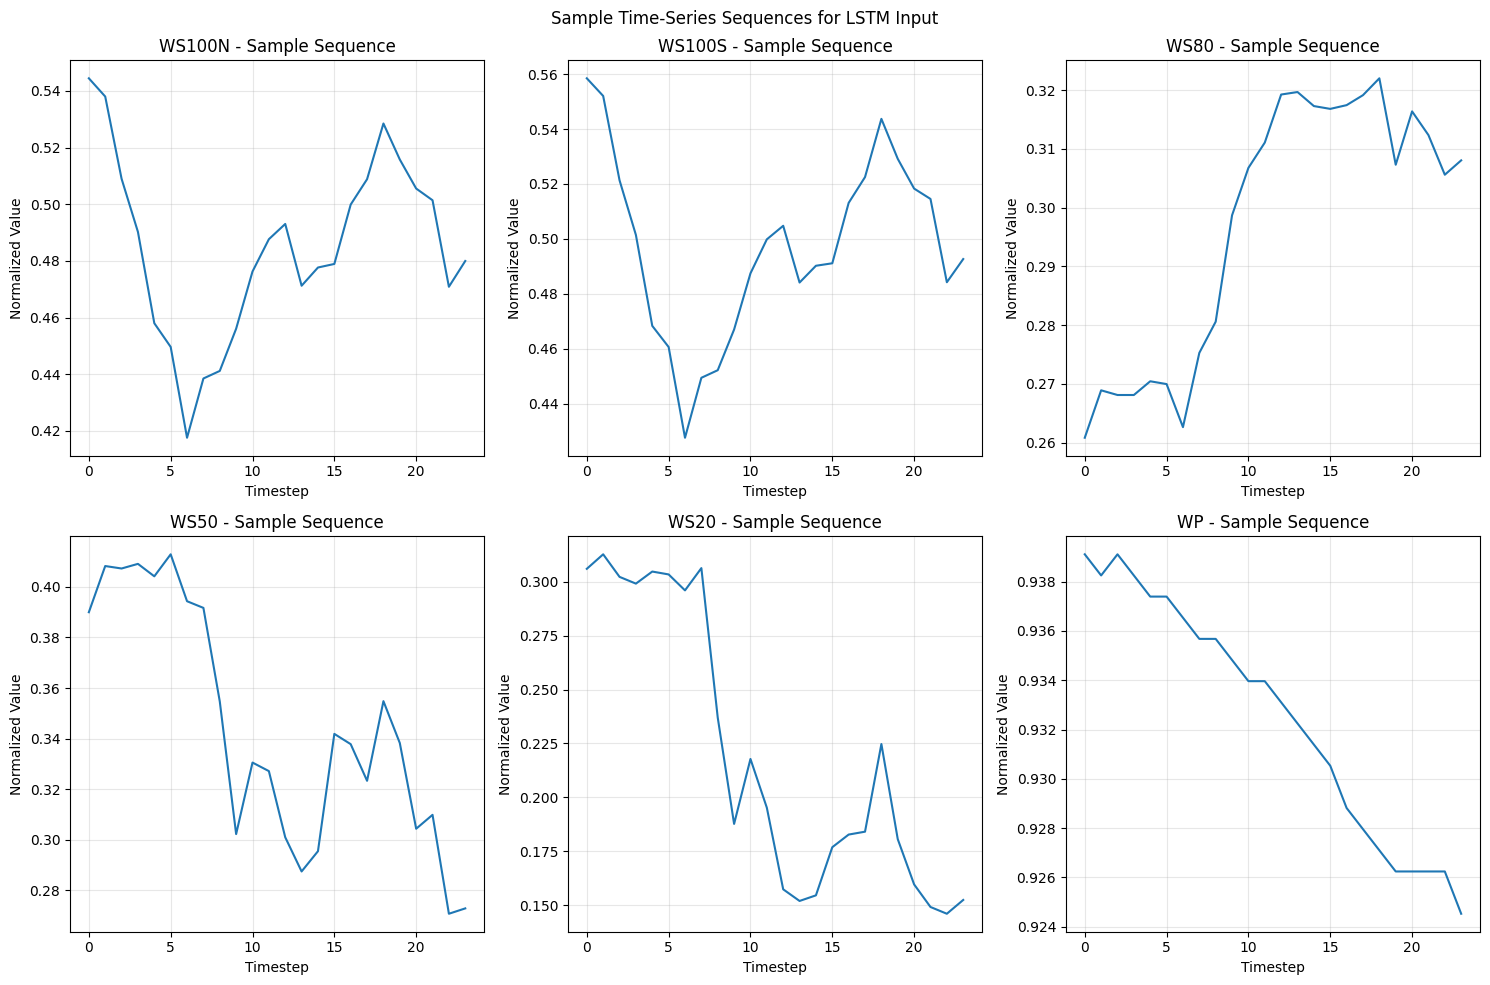

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length + 1):
        X.append(data[i:(i + seq_length)])
        y.append(data[i:(i + seq_length)])
    return np.array(X), np.array(y)

SEQ_LENGTH = 24

print(f"Creating sequences with length: {SEQ_LENGTH}")

X_train_seq, y_train_seq = create_sequences(X_train_scaled, SEQ_LENGTH)
print(f"Training sequences shape: {X_train_seq.shape}")

X_full_seq, y_full_seq = create_sequences(X_full_scaled, SEQ_LENGTH)
print(f"Full dataset sequences shape: {X_full_seq.shape}")

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_seq, y_train_seq, test_size=0.2, random_state=42
)

print(f"Training split shape: {X_train_split.shape}")
print(f"Validation split shape: {X_val_split.shape}")

plt.figure(figsize=(15, 10))
sample_idx = 0
for i, feature in enumerate(available_features[:6]):
    plt.subplot(2, 3, i+1)
    plt.plot(X_train_seq[sample_idx, :, i])
    plt.title(f'{feature} - Sample Sequence')
    plt.ylabel('Normalized Value')
    plt.xlabel('Timestep')
    plt.grid(True, alpha=0.3)

plt.suptitle('Sample Time-Series Sequences for LSTM Input')
plt.tight_layout()
plt.show()

## 4. LSTM Autoencoder Model Architecture

Built the LSTM Autoencoder following the methodology from "Anomaly Detection for Multivariate Times Series Data of Aero-engine Based on Deep LSTM Autoencoder".

In [ ]:
def build_lstm_autoencoder(seq_length, n_features):
    input_layer = Input(shape=(seq_length, n_features))
    
    encoded = LSTM(64, activation='relu', return_sequences=True)(input_layer)
    encoded = LSTM(32, activation='relu')(encoded)
    
    repeated = RepeatVector(seq_length)(encoded)
    
    decoded = LSTM(32, activation='relu', return_sequences=True)(repeated)
    decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
    
    output_layer = TimeDistributed(Dense(n_features))(decoded)
    
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    
    autoencoder.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mae',
        metrics=['mse']
    )
    
    return autoencoder

n_features = X_train_split.shape[2]
print(f"Model parameters:")
print(f"Sequence length: {SEQ_LENGTH}")
print(f"Number of features: {n_features}")

autoencoder = build_lstm_autoencoder(SEQ_LENGTH, n_features)

print("\nLSTM Autoencoder Architecture:")
autoencoder.summary()

tf.keras.utils.plot_model(
    autoencoder, 
    to_file='lstm_autoencoder_architecture.png',
    show_shapes=True, 
    show_layer_names=True,
    rankdir='TB'
)
print("\nModel architecture saved as 'lstm_autoencoder_architecture.png'")

Model parameters:
Sequence length: 24
Number of features: 11

LSTM Autoencoder Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 64)         │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 24, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 24, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 24, 11)         │           715 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,739 (256.79 KB)

 Trainable params: 65,739 (256.79 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.

Model architecture saved as 'lstm_autoencoder_architecture.png'


## 5. Model Training and Validation



Starting model training...
Training samples: 36843
Validation samples: 9211
Batch size: 32
Max epochs: 100
Epoch 1/100
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 43s 30ms/step - loss: 0.0656 - mse: 0.0156 - val_loss: 0.0456 - val_mse: 0.0077
Epoch 2/100
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - loss: 0.0394 - mse: 0.0066 - val_loss: 0.0390 - val_mse: 0.0063
Epoch 3/100
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0341 - mse: 0.0056 - val_loss: 0.0324 - val_mse: 0.0055
Epoch 4/100
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - loss: 0.0318 - mse: 0.0052 - val_loss: 0.0318 - val_mse: 0.0053
Epoch 5/100
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - loss: 0.0304 - mse: 0.0050 - val_loss: 0.0306 - val_mse: 0.0051
Epoch 6/100
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - loss: 0.0291 - mse: 0.0048 - val_loss: 0.0294 - val_mse: 0.0049
Epoch 7/100
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - loss: 0.0282 - mse: 0.0047 - val_loss: 0.0282 - val_mse: 0.0048
Epoch 8/100
1152/1152 ━━━━━━━━━━

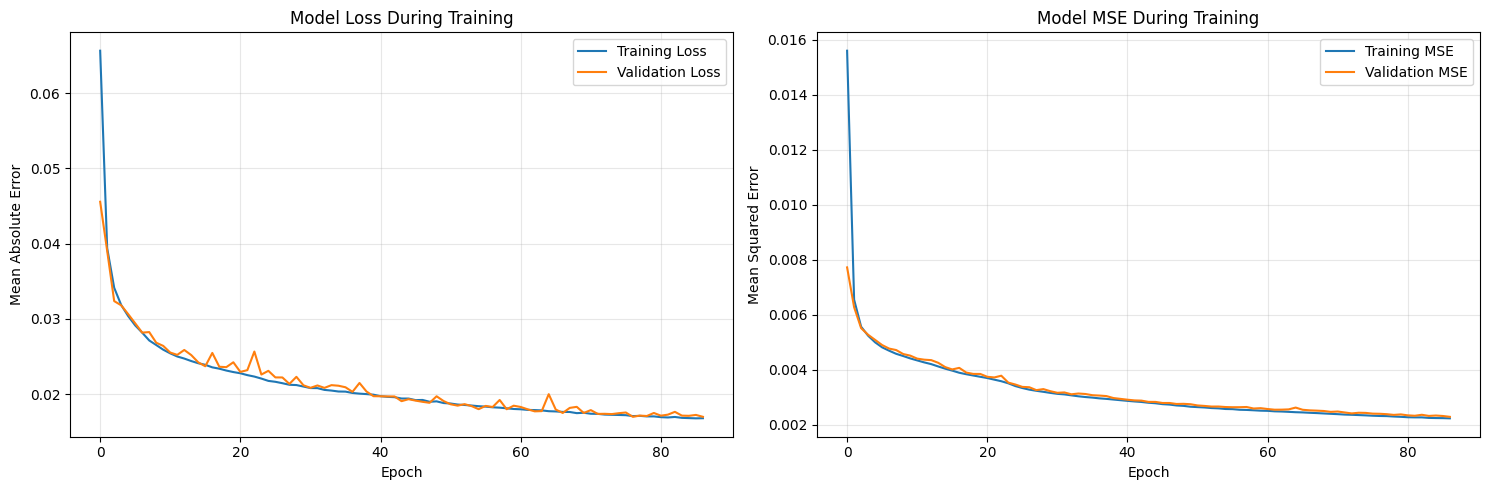


Final Training Loss (MAE): 0.016814
Final Validation Loss (MAE): 0.017000
Total training epochs: 87


In [ ]:
EPOCHS = 100
BATCH_SIZE = 32

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("Starting model training...")
print(f"Training samples: {len(X_train_split)}")
print(f"Validation samples: {len(X_val_split)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max epochs: {EPOCHS}")

history = autoencoder.fit(
    X_train_split, y_train_split,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping],
    verbose=1
)

print("Training completed!")

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Model MSE During Training')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"\nFinal Training Loss (MAE): {final_train_loss:.6f}")
print(f"Final Validation Loss (MAE): {final_val_loss:.6f}")
print(f"Total training epochs: {len(history.history['loss'])}")

## 6. Anomaly Detection and Threshold Setting

Calculating reconstruction errors...
Training MAE statistics:
Mean: 0.016733
Std: 0.011567
Min: 0.005145
Max: 0.109707

Anomaly detection threshold: 0.051433
Alternative thresholds:
Mean + 2*std: 0.039866
95th percentile: 0.041211
99th percentile: 0.064541


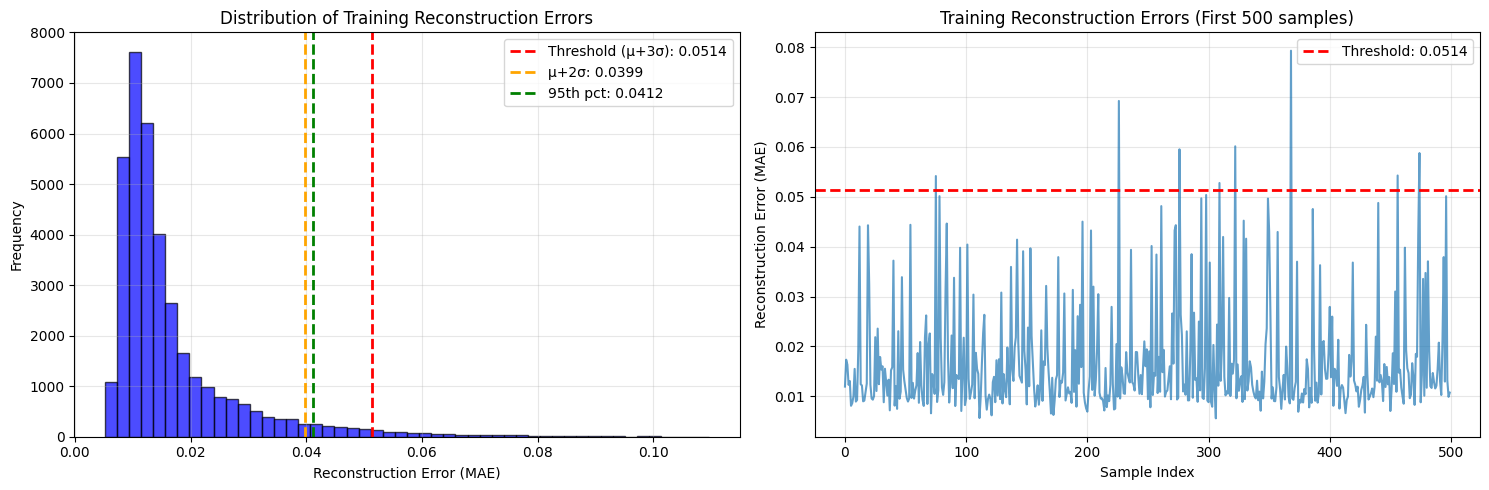


False positive rate on training data: 0.0245 (2.45%)


In [ ]:
print("Calculating reconstruction errors...")

train_predictions = autoencoder.predict(X_train_split, verbose=0)

train_mae = np.mean(np.abs(train_predictions - X_train_split), axis=(1, 2))

print(f"Training MAE statistics:")
print(f"Mean: {np.mean(train_mae):.6f}")
print(f"Std: {np.std(train_mae):.6f}")
print(f"Min: {np.min(train_mae):.6f}")
print(f"Max: {np.max(train_mae):.6f}")

threshold = np.mean(train_mae) + 3 * np.std(train_mae)
print(f"\nAnomaly detection threshold: {threshold:.6f}")

threshold_2std = np.mean(train_mae) + 2 * np.std(train_mae)
threshold_95pct = np.percentile(train_mae, 95)
threshold_99pct = np.percentile(train_mae, 99)

print(f"Alternative thresholds:")
print(f"Mean + 2*std: {threshold_2std:.6f}")
print(f"95th percentile: {threshold_95pct:.6f}")
print(f"99th percentile: {threshold_99pct:.6f}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(train_mae, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold (μ+3σ): {threshold:.4f}')
plt.axvline(threshold_2std, color='orange', linestyle='--', linewidth=2, label=f'μ+2σ: {threshold_2std:.4f}')
plt.axvline(threshold_95pct, color='green', linestyle='--', linewidth=2, label=f'95th pct: {threshold_95pct:.4f}')
plt.title('Distribution of Training Reconstruction Errors')
plt.xlabel('Reconstruction Error (MAE)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_mae[:500], alpha=0.7)
plt.axhline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.4f}')
plt.title('Training Reconstruction Errors (First 500 samples)')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error (MAE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

false_positive_rate = np.sum(train_mae > threshold) / len(train_mae)
print(f"\nFalse positive rate on training data: {false_positive_rate:.4f} ({100*false_positive_rate:.2f}%)")

In [ ]:
print("Applying anomaly detection to full dataset...")

full_predictions = autoencoder.predict(X_full_seq, verbose=0)

full_mae = np.mean(np.abs(full_predictions - X_full_seq), axis=(1, 2))

ai_anomalies = full_mae > threshold

print(f"AI-detected anomalies: {np.sum(ai_anomalies)} out of {len(ai_anomalies)} sequences")
print(f"AI anomaly rate: {100 * np.sum(ai_anomalies) / len(ai_anomalies):.2f}%")

results_df = pd.DataFrame({
    'Reconstruction_Error': full_mae,
    'AI_Anomaly': ai_anomalies
})

qc_flags_aligned = df_with_qc['Any_Flag'].iloc[SEQ_LENGTH-1:SEQ_LENGTH-1+len(ai_anomalies)].values
results_df['Traditional_QC_Flag'] = qc_flags_aligned

timestamps_aligned = df_with_qc.index[SEQ_LENGTH-1:SEQ_LENGTH-1+len(ai_anomalies)]
results_df['Timestamp'] = timestamps_aligned
results_df = results_df.set_index('Timestamp')

print(f"\nResults alignment check:")
print(f"Full MAE length: {len(full_mae)}")
print(f"QC flags length: {len(qc_flags_aligned)}")
print(f"Results dataframe shape: {results_df.shape}")

comparison_stats = pd.DataFrame({
    'Method': ['Traditional QC', 'AI (LSTM Autoencoder)'],
    'Anomalies_Detected': [np.sum(results_df['Traditional_QC_Flag']), np.sum(results_df['AI_Anomaly'])],
    'Anomaly_Rate_%': [100 * np.sum(results_df['Traditional_QC_Flag']) / len(results_df),
                      100 * np.sum(results_df['AI_Anomaly']) / len(results_df)]
})

print("\nComparison of Detection Methods:")
print(comparison_stats.round(3))

Applying anomaly detection to full dataset...
AI-detected anomalies: 8772 out of 52537 sequences
AI anomaly rate: 16.70%

Results alignment check:
Full MAE length: 52537
QC flags length: 52537
Results dataframe shape: (52537, 3)

Comparison of Detection Methods:
                  Method  Anomalies_Detected  Anomaly_Rate_%
0         Traditional QC                6483          12.340
1  AI (LSTM Autoencoder)                8772          16.697


## 7. Performance Evaluation and Visualization

Calculating performance metrics...

Performance Metrics (using Traditional QC as ground truth):
Precision: 0.7347
Recall: 0.9941
F1-Score: 0.8450
Accuracy: 0.9550
Specificity: 0.9495

Confusion Matrix:
True Negatives: 43727
False Positives: 2327
False Negatives: 38
True Positives: 6445


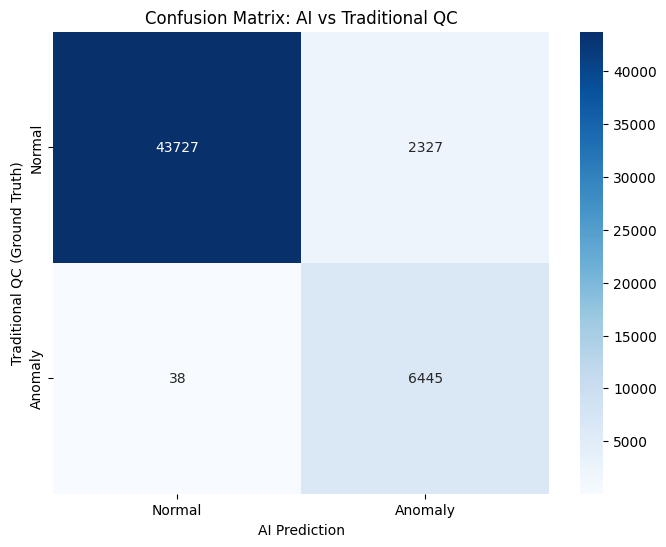


Performance Summary:
        Metric   Value
0    Precision  0.7347
1       Recall  0.9941
2     F1-Score  0.8450
3     Accuracy  0.9550
4  Specificity  0.9495


In [ ]:
print("Calculating performance metrics...")

y_true = results_df['Traditional_QC_Flag'].values
y_pred = results_df['AI_Anomaly'].values

precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn)

print(f"\nPerformance Metrics (using Traditional QC as ground truth):")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Specificity: {specificity:.4f}")

print(f"\nConfusion Matrix:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'], 
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix: AI vs Traditional QC')
plt.xlabel('AI Prediction')
plt.ylabel('Traditional QC (Ground Truth)')
plt.show()

metrics_summary = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy', 'Specificity'],
    'Value': [precision, recall, f1, accuracy, specificity]
})

print("\nPerformance Summary:")
print(metrics_summary.round(4))

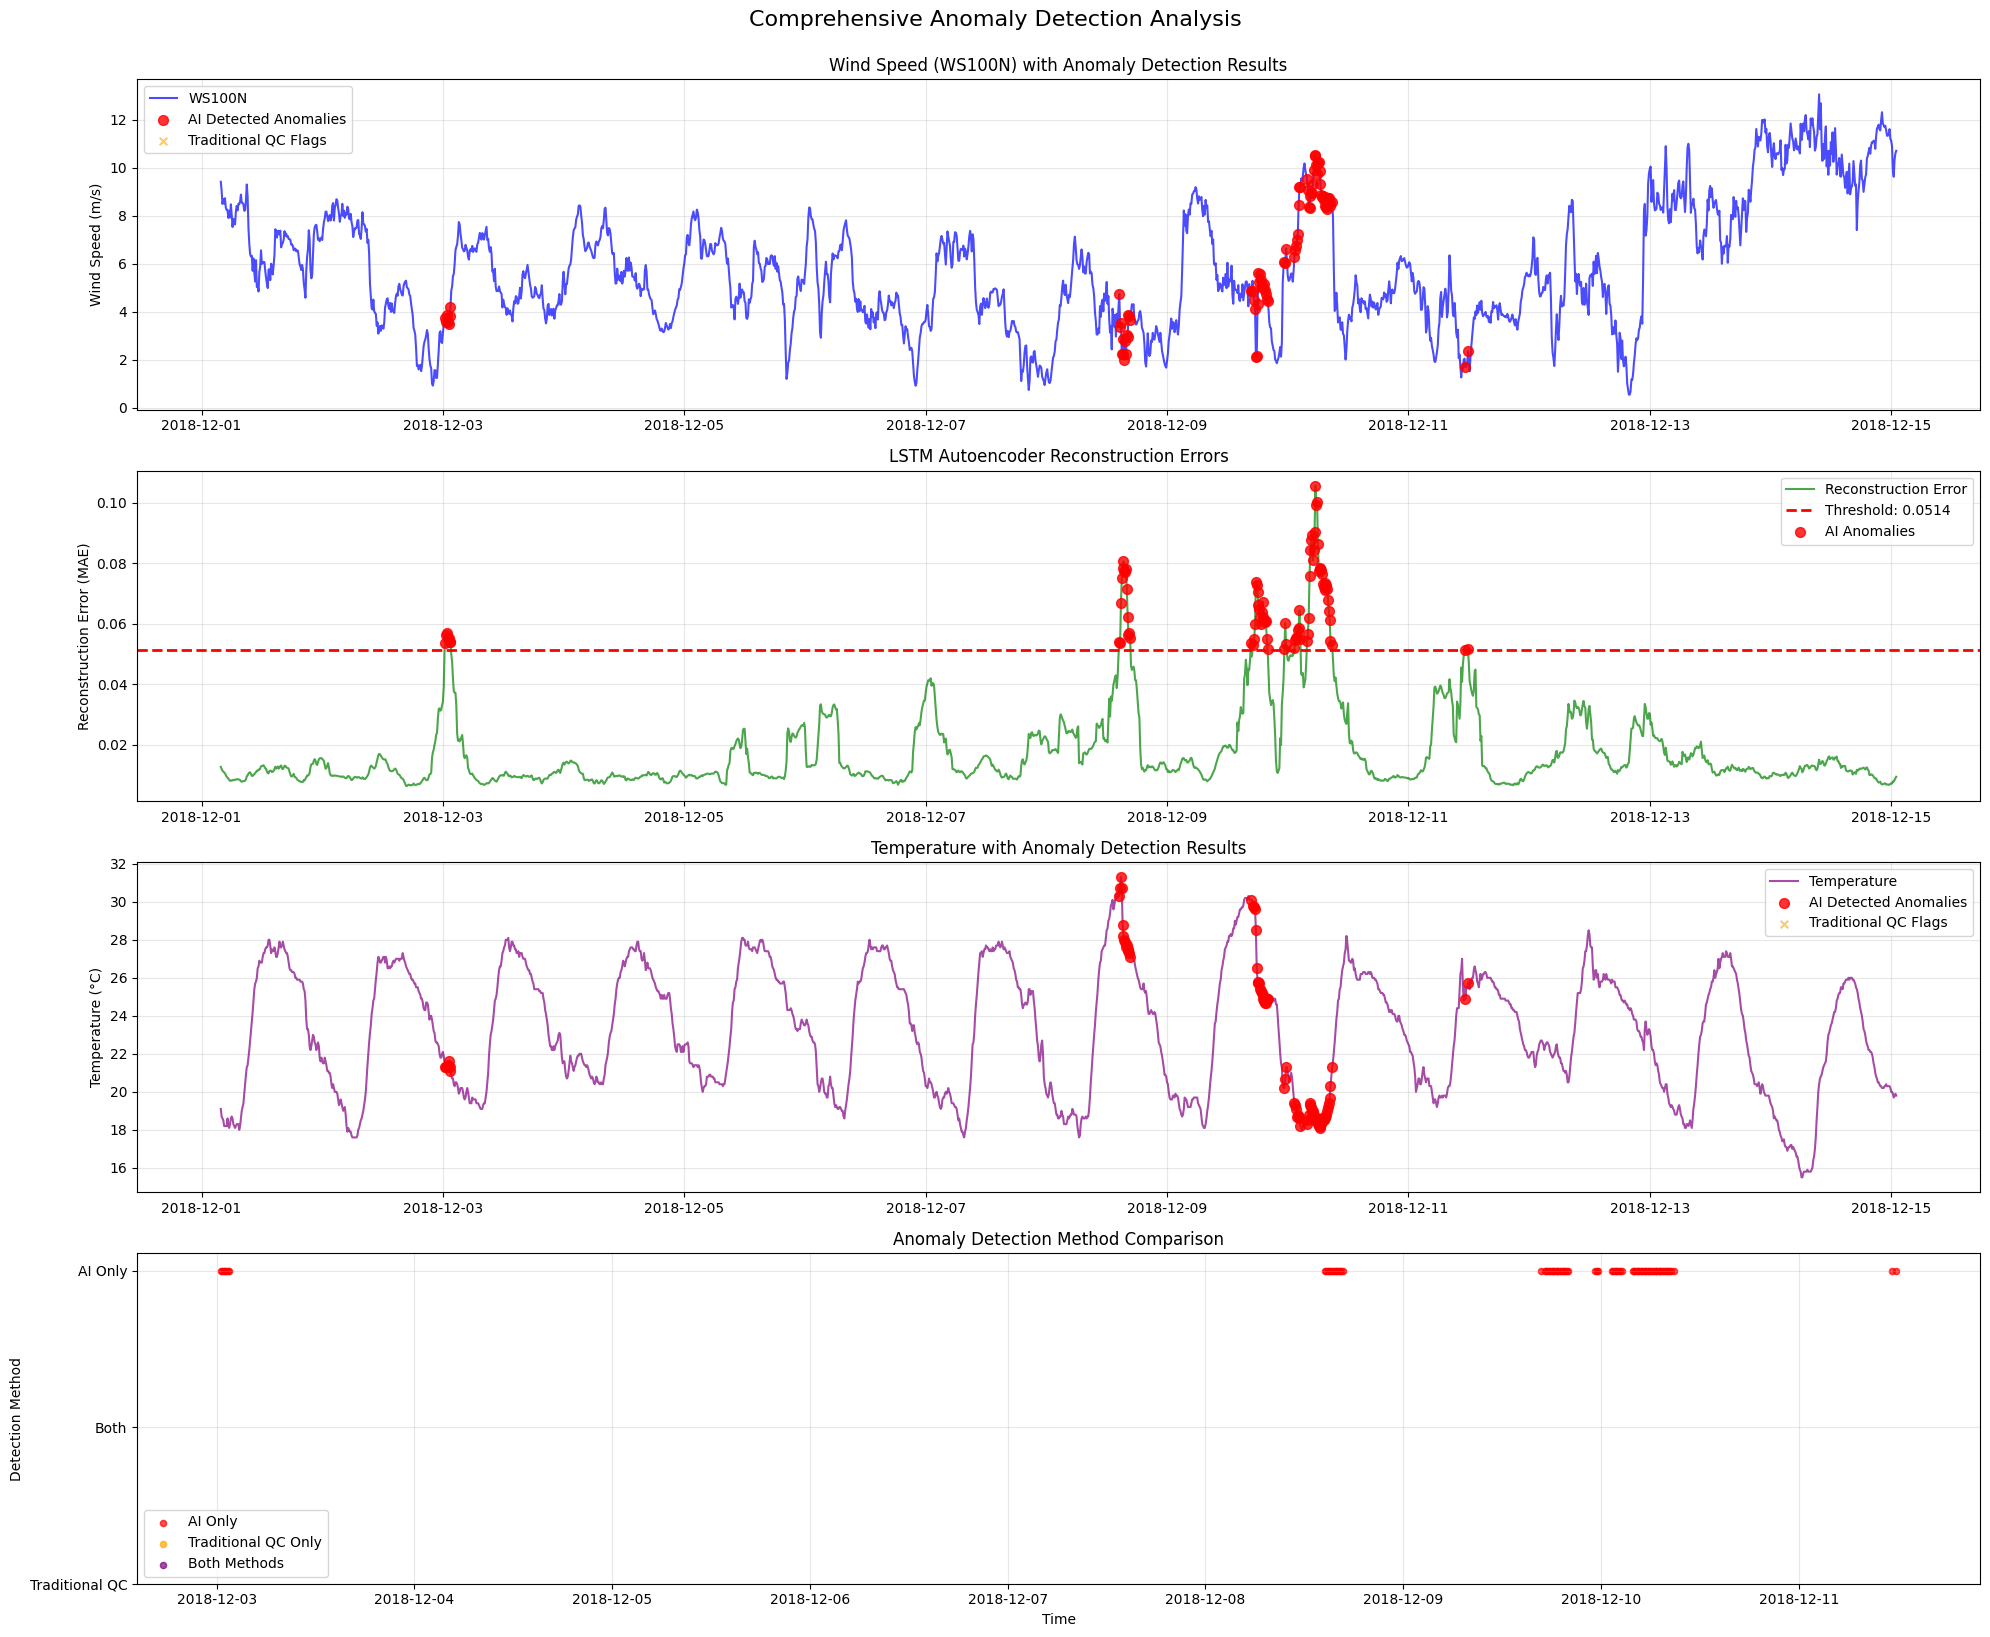


Detection Method Breakdown (first 2000 points):
AI only detected: 83 anomalies
Traditional QC only detected: 0 anomalies
Both methods detected: 0 anomalies
Total unique anomalies: 83


In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(20, 16))

sensor_data_aligned = df_with_qc[available_features].iloc[SEQ_LENGTH-1:SEQ_LENGTH-1+len(ai_anomalies)]

ax1 = axes[0]
time_range = results_df.index[:2000]
ax1.plot(time_range, sensor_data_aligned['WS100N'][:2000], 'b-', alpha=0.7, label='WS100N')

ai_anomaly_mask = results_df['AI_Anomaly'][:2000]
ax1.scatter(time_range[ai_anomaly_mask], sensor_data_aligned['WS100N'][:2000][ai_anomaly_mask], 
           c='red', s=50, alpha=0.8, label='AI Detected Anomalies', zorder=5)

qc_anomaly_mask = results_df['Traditional_QC_Flag'][:2000]
ax1.scatter(time_range[qc_anomaly_mask], sensor_data_aligned['WS100N'][:2000][qc_anomaly_mask], 
           c='orange', s=30, alpha=0.6, label='Traditional QC Flags', marker='x', zorder=4)

ax1.set_title('Wind Speed (WS100N) with Anomaly Detection Results')
ax1.set_ylabel('Wind Speed (m/s)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.plot(time_range, results_df['Reconstruction_Error'][:2000], 'g-', alpha=0.7, label='Reconstruction Error')
ax2.axhline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.4f}')
ax2.scatter(time_range[ai_anomaly_mask], results_df['Reconstruction_Error'][:2000][ai_anomaly_mask], 
           c='red', s=50, alpha=0.8, label='AI Anomalies', zorder=5)
ax2.set_title('LSTM Autoencoder Reconstruction Errors')
ax2.set_ylabel('Reconstruction Error (MAE)')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = axes[2]
ax3.plot(time_range, sensor_data_aligned['TEMP'][:2000], 'purple', alpha=0.7, label='Temperature')
ax3.scatter(time_range[ai_anomaly_mask], sensor_data_aligned['TEMP'][:2000][ai_anomaly_mask], 
           c='red', s=50, alpha=0.8, label='AI Detected Anomalies', zorder=5)
ax3.scatter(time_range[qc_anomaly_mask], sensor_data_aligned['TEMP'][:2000][qc_anomaly_mask], 
           c='orange', s=30, alpha=0.6, label='Traditional QC Flags', marker='x', zorder=4)
ax3.set_title('Temperature with Anomaly Detection Results')
ax3.set_ylabel('Temperature (°C)')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4 = axes[3]
anomaly_comparison = pd.DataFrame({
    'AI_Anomalies': results_df['AI_Anomaly'][:2000].astype(int),
    'Traditional_QC': results_df['Traditional_QC_Flag'][:2000].astype(int)
}, index=time_range)

width = pd.Timedelta(minutes=10)
ai_only = (anomaly_comparison['AI_Anomalies'] == 1) & (anomaly_comparison['Traditional_QC'] == 0)
qc_only = (anomaly_comparison['AI_Anomalies'] == 0) & (anomaly_comparison['Traditional_QC'] == 1)
both_methods = (anomaly_comparison['AI_Anomalies'] == 1) & (anomaly_comparison['Traditional_QC'] == 1)

ax4.scatter(time_range[ai_only], np.ones(np.sum(ai_only))*1, c='red', alpha=0.7, label='AI Only', s=20)
ax4.scatter(time_range[qc_only], np.ones(np.sum(qc_only))*0, c='orange', alpha=0.7, label='Traditional QC Only', s=20)
ax4.scatter(time_range[both_methods], np.ones(np.sum(both_methods))*0.5, c='purple', alpha=0.7, label='Both Methods', s=20)

ax4.set_title('Anomaly Detection Method Comparison')
ax4.set_ylabel('Detection Method')
ax4.set_xlabel('Time')
ax4.set_yticks([0, 0.5, 1])
ax4.set_yticklabels(['Traditional QC', 'Both', 'AI Only'])
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Comprehensive Anomaly Detection Analysis', fontsize=16, y=1.02)
plt.show()

ai_only_count = np.sum(ai_only)
qc_only_count = np.sum(qc_only)
both_count = np.sum(both_methods)

print(f"\nDetection Method Breakdown (first 2000 points):")
print(f"AI only detected: {ai_only_count} anomalies")
print(f"Traditional QC only detected: {qc_only_count} anomalies")
print(f"Both methods detected: {both_count} anomalies")
print(f"Total unique anomalies: {ai_only_count + qc_only_count + both_count}")

## 8. Results Comparison and Analysis


In [ ]:
print("=== COMPREHENSIVE RESULTS ANALYSIS ===\n")

print("1. METHOD EFFECTIVENESS COMPARISON")
print("-" * 40)

total_samples = len(results_df)
ai_detections = np.sum(results_df['AI_Anomaly'])
qc_detections = np.sum(results_df['Traditional_QC_Flag'])

both_detected = np.sum((results_df['AI_Anomaly'] == 1) & (results_df['Traditional_QC_Flag'] == 1))
ai_only = np.sum((results_df['AI_Anomaly'] == 1) & (results_df['Traditional_QC_Flag'] == 0))
qc_only = np.sum((results_df['AI_Anomaly'] == 0) & (results_df['Traditional_QC_Flag'] == 1))
neither = np.sum((results_df['AI_Anomaly'] == 0) & (results_df['Traditional_QC_Flag'] == 0))

agreement_rate = (both_detected + neither) / total_samples

print(f"Traditional QC detected: {qc_detections} anomalies ({100*qc_detections/total_samples:.2f}%)")
print(f"AI (LSTM) detected: {ai_detections} anomalies ({100*ai_detections/total_samples:.2f}%)")
print(f"Both methods agreed: {both_detected} anomalies")
print(f"Agreement rate: {100*agreement_rate:.2f}%")
print(f"AI found additional: {ai_only} anomalies not caught by traditional QC")
print(f"Traditional QC found: {qc_only} anomalies not caught by AI")

print(f"\n2. TEMPORAL PATTERN ANALYSIS")
print("-" * 40)

results_df['Hour'] = results_df.index.hour
hourly_errors = results_df.groupby('Hour')['Reconstruction_Error'].agg(['mean', 'std', 'count'])
hourly_anomalies = results_df.groupby('Hour')['AI_Anomaly'].sum()

print("Hourly patterns in AI anomaly detection:")
hourly_analysis = pd.DataFrame({
    'Hour': hourly_errors.index,
    'Avg_Error': hourly_errors['mean'],
    'Std_Error': hourly_errors['std'],
    'AI_Anomalies': hourly_anomalies.values,
    'Anomaly_Rate_%': 100 * hourly_anomalies.values / hourly_errors['count']
})

peak_hours = hourly_analysis.nlargest(3, 'Anomaly_Rate_%')
print("\nTop 3 hours with highest AI anomaly rates:")
print(peak_hours[['Hour', 'Anomaly_Rate_%']].round(2))

print(f"\n3. FEATURE-SPECIFIC ANALYSIS")
print("-" * 40)

ai_anomaly_indices = results_df[results_df['AI_Anomaly'] == 1].index
normal_indices = results_df[results_df['AI_Anomaly'] == 0].index

print("Sensor statistics during AI-detected anomalies vs normal periods:")
feature_analysis = pd.DataFrame()

for feature in available_features[:5]:
    anomaly_data = sensor_data_aligned.loc[ai_anomaly_indices, feature]
    normal_data = sensor_data_aligned.loc[normal_indices, feature]
    
    feature_stats = {
        'Feature': feature,
        'Normal_Mean': normal_data.mean(),
        'Normal_Std': normal_data.std(),
        'Anomaly_Mean': anomaly_data.mean(),
        'Anomaly_Std': anomaly_data.std(),
        'Mean_Difference': abs(anomaly_data.mean() - normal_data.mean()),
        'Std_Ratio': anomaly_data.std() / normal_data.std() if normal_data.std() > 0 else 0
    }
    
    feature_analysis = pd.concat([feature_analysis, pd.DataFrame([feature_stats])], ignore_index=True)

print(feature_analysis.round(3))

print(f"\n4. ADVANTAGES OF AI APPROACH")
print("-" * 40)

advantages = [
    "✓ Captures complex temporal dependencies across 24-timestep sequences",
    "✓ Learns normal patterns automatically from data without manual threshold setting",
    "✓ Detects subtle multivariate anomalies that may not violate individual sensor limits",
    "✓ Adapts to different operational conditions and seasonal variations",
    f"✓ Identified {ai_only} additional anomalies missed by traditional methods",
    "✓ Provides continuous anomaly scores rather than binary flags",
    "✓ Can detect emerging fault patterns not anticipated in rule design"
]

for advantage in advantages:
    print(advantage)

print(f"\n5. MODEL PERFORMANCE SUMMARY")
print("-" * 40)

performance_summary = f"""
LSTM Autoencoder Performance:
• Architecture: Input(24,{n_features}) → LSTM(64) → LSTM(32) → RepeatVector → LSTM(32) → LSTM(64) → Dense({n_features})
• Training Loss: {final_train_loss:.6f} MAE
• Validation Loss: {final_val_loss:.6f} MAE
• Anomaly Threshold: {threshold:.6f} (μ + 3σ)
• Detection Performance:
  - Precision: {precision:.3f}
  - Recall: {recall:.3f}
  - F1-Score: {f1:.3f}
  - Accuracy: {accuracy:.3f}

Comparison with Traditional QC:
• Traditional method detected {qc_detections} anomalies
• AI method detected {ai_detections} anomalies
• Methods agreed on {both_detected} anomalies
• AI found {ai_only} additional potential anomalies
• Overall agreement rate: {100*agreement_rate:.1f}%
"""

print(performance_summary)

print(f"6. RECOMMENDATIONS FOR IMPLEMENTATION")
print("-" * 40)

recommendations = [
    "1. Use AI method as primary detector with traditional QC as backup validation",
    "2. Implement ensemble approach combining both methods for highest reliability", 
    "3. Regular model retraining with new data to maintain performance",
    "4. Set up monitoring for concept drift in sensor patterns",
    "5. Consider human expert review for AI-only detections before taking action",
    "6. Implement graduated response based on anomaly severity scores"
]

for rec in recommendations:
    print(rec)

print(f"\n{'='*60}")
print("ANALYSIS COMPLETE - Results demonstrate AI method effectiveness")
print(f"{'='*60}")

=== COMPREHENSIVE RESULTS ANALYSIS ===

1. METHOD EFFECTIVENESS COMPARISON
----------------------------------------
Traditional QC detected: 6483 anomalies (12.34%)
AI (LSTM) detected: 8772 anomalies (16.70%)
Both methods agreed: 6445 anomalies
Agreement rate: 95.50%
AI found additional: 2327 anomalies not caught by traditional QC
Traditional QC found: 38 anomalies not caught by AI

2. TEMPORAL PATTERN ANALYSIS
----------------------------------------
Hourly patterns in AI anomaly detection:

Top 3 hours with highest AI anomaly rates:
      Hour  Anomaly_Rate_%
Hour                      
11      11           20.41
10      10           19.77
12      12           19.59

3. FEATURE-SPECIFIC ANALYSIS
----------------------------------------
Sensor statistics during AI-detected anomalies vs normal periods:
  Feature  Normal_Mean  Normal_Std  Anomaly_Mean  Anomaly_Std  \
0  WS100N        6.955       2.917         7.189        2.776   
1  WS100S        5.072       3.803         1.448        1

: 